In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

In [2]:
#Import data from file saved on system
Infy = pd.read_csv('Infy-His-data2018-20.csv')
print (Infy.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2018-01-01  518.849976  522.250000  515.000000  516.775024  474.472595   
1  2018-01-02  518.625000  521.000000  511.500000  514.849976  472.705139   
2  2018-01-03  514.250000  515.799988  509.299988  510.649994  468.848938   
3  2018-01-04  510.500000  510.500000  504.799988  507.700012  466.140472   
4  2018-01-05  507.649994  513.200012  503.000000  506.000000  464.579559   

     Volume  
0   5431340  
1   6112248  
2   6846552  
3   8947614  
4  11025976  


In [7]:
import warnings
warnings.filterwarnings("ignore")

# Get just the close in file 'T1'
T1 = pd.DataFrame({"Date": Infy["Date"], "Close": Infy["Close"]})

# Window length for moving average
window_length = 14

# Get the difference in price from previous step
T1['delta'] = T1['Close'].diff()


# Make the positive gains (up) and negative gains (down) Series
T1['up'] = T1['delta']
T1['down'] = T1['delta']

for x in range (len(T1)):
    if T1.up[x] < 0:
        T1.up[x] = 0
    if T1.down[x] > 0:
        T1.down[x] = 0

# Calculate the SMA
T1['roll_up'] = T1['up'].rolling(window_length).mean()
T1['roll_down'] = T1['down'].abs().rolling(window_length).mean()

# Calculate the RSI based on SMA
T1['RS'] = T1['roll_up'] / T1['roll_down']
T1['RSI'] = 100.0 - (100.0 / (1.0 + T1['RS']))

print (T1)

           Date        Close      delta         up       down    roll_up  \
0    2018-01-01   516.775024        NaN        NaN        NaN        NaN   
1    2018-01-02   514.849976  -1.925049   0.000000  -1.925049        NaN   
2    2018-01-03   510.649994  -4.199982   0.000000  -4.199982        NaN   
3    2018-01-04   507.700012  -2.949982   0.000000  -2.949982        NaN   
4    2018-01-05   506.000000  -1.700012   0.000000  -1.700012        NaN   
..          ...          ...        ...        ...        ...        ...   
732  2020-12-23  1253.050049  32.550049  32.550049   0.000000  11.967869   
733  2020-12-24  1236.050049 -17.000000   0.000000 -17.000000  11.382150   
734  2020-12-28  1240.300049   4.250000   4.250000   0.000000  11.053580   
735  2020-12-29  1250.300049  10.000000  10.000000   0.000000  11.064296   
736  2020-12-30  1246.800049  -3.500000   0.000000  -3.500000   9.503584   

     roll_down        RS        RSI  
0          NaN       NaN        NaN  
1          

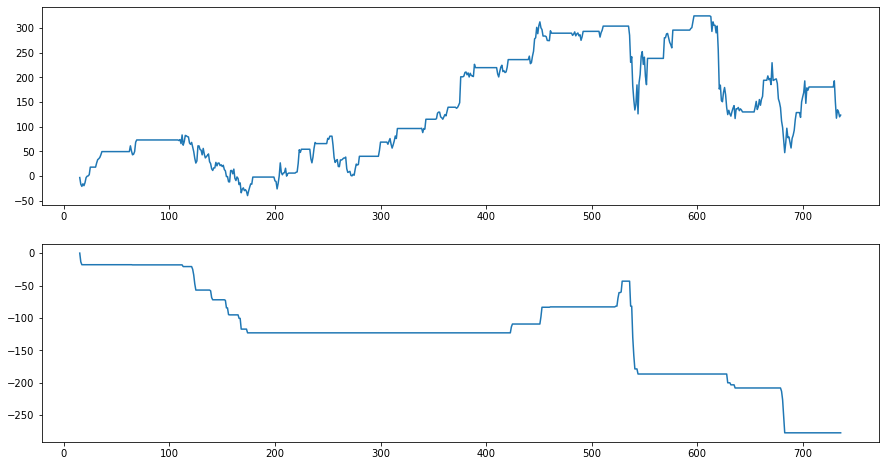

In [11]:
T1['positions_long'] = np.nan
for x in range (len(T1)):
    if T1.RSI[x] < 30:
        T1['positions_long'][x] = 1
    if T1.RSI[x] >= 50:
        T1['positions_long'][x] = 0
T1.positions_long = T1.positions_long.fillna(method='ffill')  

T1['positions_short'] = np.nan
for x in range (len(T1)):
    if T1.RSI[x] > 70:
        T1['positions_short'][x] = -1
    if T1.RSI[x] <= 50:
        T1['positions_short'][x] = 0
T1.positions_short = T1.positions_short.fillna(method='ffill')  

T1['positions'] = T1.positions_long + T1.positions_short 
T1['price_difference']= T1.Close - T1.Close.shift(1)
T1['pnl'] = T1.positions.shift(1) * T1.price_difference
T1['cumpnl'] = T1.pnl.cumsum()

# Calculate the max drawdown in the past window days for each day 
T1['rolling_max'] = T1['cumpnl'].rolling(250, min_periods=1).max()
T1['daily_drawdown'] = T1['cumpnl']-T1['rolling_max']

# Calculate the minimum (negative) daily drawdown
T1['max_daily_drawdown'] = T1['daily_drawdown'].rolling(250, min_periods=1).min()

fig, axs = plt.subplots(2,figsize=(15,8))
axs[0].plot(T1['cumpnl'])
axs[1].plot(T1['max_daily_drawdown'])


In [13]:
T1['Trade'] = T1['positions'].diff()
T2 = T1.where((T1.Trade != 0)) 
T2 = T2.dropna()
T2.drop(["delta", "up", "down", "roll_up", "roll_down", "RS", "positions_long", "positions_short", "positions", "price_difference", "pnl", "rolling_max", "daily_drawdown", "max_daily_drawdown"], axis = 1, inplace = True)
T2['Trade_Return'] = (T2['cumpnl'].diff()/T2['Close'])*100
print ("Number of Trade count", round(len(T2)/2))
print (T2)

Number of Trade count 27
           Date        Close        RSI      cumpnl  Trade  Trade_Return
25   2018-02-06   553.875000  45.673362   17.849976    1.0           NaN
30   2018-02-14   548.875000  25.918083   17.849976    1.0      0.000000
36   2018-02-22   580.375000  54.958559   49.349976   -1.0      5.427525
62   2018-04-04   562.099976  27.827288   49.349976    1.0      0.000000
69   2018-04-13   585.724976  52.716058   72.974976   -1.0      4.033463
108  2018-06-08   630.025024  70.616844   72.974976   -1.0      0.000000
179  2018-09-21   705.299988  48.659653   -2.299988    1.0    -10.672758
199  2018-10-23   657.599976  27.908687   -2.299988    1.0      0.000000
213  2018-11-13   665.700012  52.969220    5.800049   -1.0      1.216770
219  2018-11-21   619.099976  20.559953    5.800049    1.0      0.000000
225  2018-11-30   667.450012  53.313879   54.150085   -1.0      7.243994
233  2018-12-12   678.500000  72.706423   54.150085   -1.0      0.000000
239  2018-12-20   667.0499

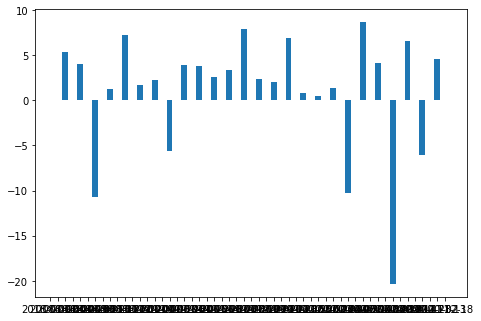

In [14]:
# Plot trade retruns
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(T2['Date'], T2['Trade_Return'])
plt.show()